In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.cluster import KMeans
import numpy.matlib
import statsmodels.formula.api as smf
from bct.algorithms.distance import retrieve_shortest_path, distance_wei_floyd
from bct.algorithms.reference import randmio_und

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pathlength_tuning/1_code/')
from func import set_proj_env, my_get_cmap, get_fdr_p, get_pdist, get_adj_stats, get_gradient_variance, nuis_regress_matrix, my_regplot, my_nullplot

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


### Parameters

In [8]:
control_list = ['minimum','minimum_taylor']; control = control_list[0]
T_list = [1,]; T = T_list[0]
B_list = ['x0xfwb',]; B_ver = B_list[0]

num_parcels=parc_scale
n_clusters=int(num_parcels*.05)
print(n_clusters)
n_subsamples = 20
n_taylor = 7

20


### Setup plots

In [9]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = my_get_cmap('pair')

# Load data

## Load group A matrix (6% sparsity)

disc_mean_A_s6_minimum_T-1_B-x0xfwb-g20


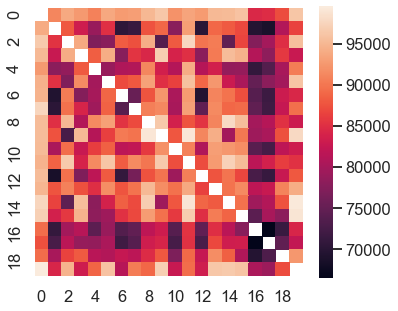

In [10]:
file_label = 'disc_mean_A_s6_'+control+'_T-'+str(T)+'_B-'+B_ver+'-g'+str(n_clusters)
print(file_label)

E_Am = np.load(os.path.join(os.environ['PIPELINEDIR'], '2_compute_energy', 'out', outfile_prefix[:-1], file_label+'_E.npy'))
E_Am = np.mean(E_Am, axis = 2)
E_Am[np.eye(E_Am.shape[0]) == 1] = np.nan

f, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(E_Am, ax=ax, square = True)

### MNI Centroids

In [11]:
centroids = pd.read_csv(os.path.join(os.environ['PROJDIR'],'figs_support','labels','schaefer'+str(parc_scale),'Schaefer2018_'+str(parc_scale)+'Parcels_17Networks_order_FSLMNI152_1mm.Centroid_RAS.csv'))
centroids.drop('ROI Name', axis = 1, inplace = True)
centroids.set_index('ROI Label', inplace=True)
centroids.head()

,R,A,S
ROI Label,,,
1,-36,-62,-17
2,-23,-73,-10
3,-36,-81,-16
4,-17,-86,-15
5,-24,-97,-12


In [12]:
os.environ['PIPELINEDIR']

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline'

In [13]:
D = sp.spatial.distance.pdist(centroids, 'euclidean')

D = sp.spatial.distance.squareform(D)
np.save(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'D'), D)

## Plot cortical gradients

[58 17 14 16 17 10 17 37 19 32 19 29 11 30  7  7 10 23  7 20]


Text(0, 0.5, 'Gradient 1')

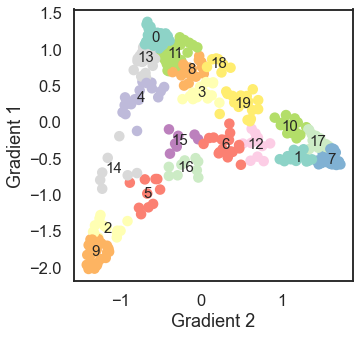

In [14]:
gradients = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '1_compute_gradient', 'out', outfile_prefix+'pnc_grads_template.txt'))
num_parcels = gradients.shape[0]

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(gradients)

unique, counts = np.unique(kmeans.labels_, return_counts = True)
print(counts)

f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(gradients[:,1], gradients[:,0], c = kmeans.labels_, cmap= 'Set3')
# ax.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], marker = 'x', c = 'k', s = 100)
for i, txt in enumerate(np.arange(n_clusters)):
    ax.annotate(txt, (kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0]), ha="center", va="center", size=15)
ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')

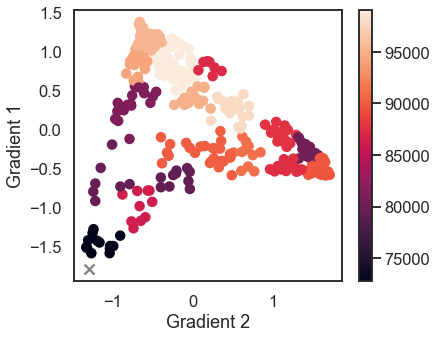

In [15]:
i = 9
colormask = np.zeros(num_parcels)
for j in np.arange(n_clusters):
    if j != i:
        colormask[kmeans.labels_ == j] = E_Am[i,j]
    else:
        colormask[kmeans.labels_ == j] = np.nan

f, ax = plt.subplots(figsize=(6, 5))
im = ax.scatter(gradients[:,1], gradients[:,0], c = colormask)
ax.scatter(kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0], marker = 'x', c = 'gray', s = 100)
ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')
f.colorbar(im, ax=ax)

## Plot paths traversing cortical gradients

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/bct/algorithms/distance.py:392: RuntimeWarning: divide by zero encountered in true_divide
  SPL = 1. / adjacency


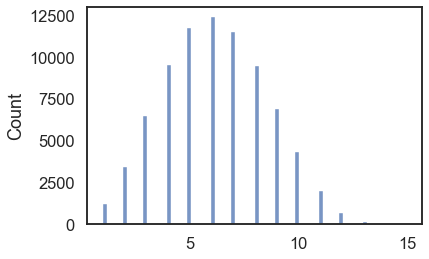

In [16]:
A = np.load(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'disc_mean_A_s8.npy'))
D_mean, hops_mean, tm_con, tm_var, smv_con, smv_var, joint_var, num_tm_flips, num_smv_flips = get_adj_stats(A, gradients, kmeans.labels_, return_abs = False)

D, hops, Pmat = distance_wei_floyd(A, transform = 'inv')
sns.histplot(hops[np.triu_indices(num_parcels, k=1)])

172 47
117 192
323 251
195 359
9 211


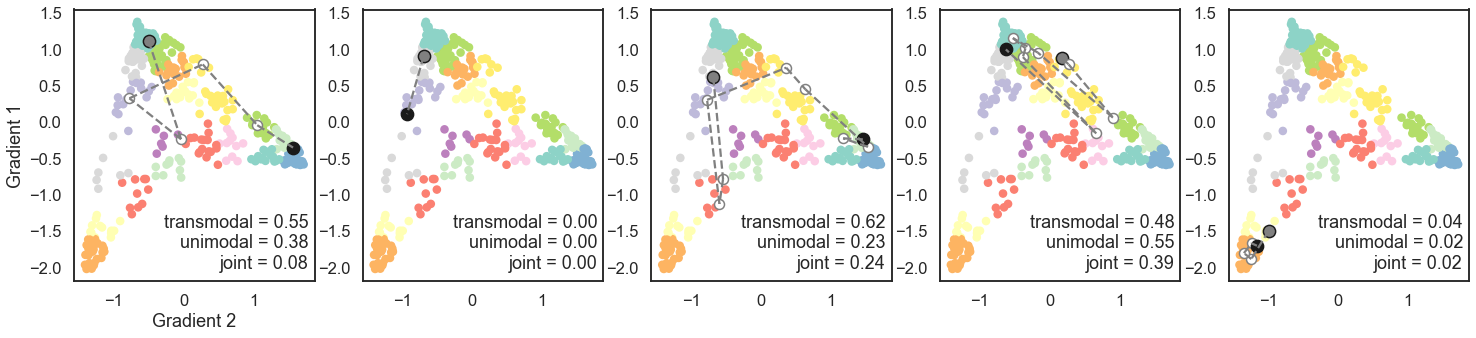

In [17]:
np.random.seed(0)

f, ax = plt.subplots(1, 5, figsize=(5*5, 5))

for sbp in np.arange(5):
    idx_i = np.random.randint(0, num_parcels)
#     idx_i = 316
    idx_j = np.random.randint(0, num_parcels)
    while idx_i == idx_j:
        idx_j = np.random.randint(0, num_parcels)
    
    print(idx_i, idx_j)

    shortest_path = retrieve_shortest_path(idx_i,idx_j,hops,Pmat)
    shortest_path = shortest_path.flatten()

    path_mask = np.zeros(num_parcels)
    path_mask[shortest_path] = 1

    ax[sbp].scatter(gradients[:,1], gradients[:,0], c = kmeans.labels_, cmap= 'Set3', s=50)

    for i in np.arange(len(shortest_path)-1):
        ax[sbp].plot([gradients[shortest_path[i],1], gradients[shortest_path[i+1],1]],
                [gradients[shortest_path[i],0], gradients[shortest_path[i+1],0]],
                linestyle = '--', color = 'gray')

    for i in np.arange(len(shortest_path)):
        if i == 0:
            ax[sbp].scatter(gradients[shortest_path[i],1], gradients[shortest_path[i],0], marker = 'o', edgecolor = 'k', facecolor = 'gray', s=150)
        elif i == len(shortest_path)-1:
            ax[sbp].scatter(gradients[shortest_path[i],1], gradients[shortest_path[i],0], marker = 'o', edgecolor = 'k', facecolor = 'k', s=150)
        else:
            ax[sbp].scatter(gradients[shortest_path[i],1], gradients[shortest_path[i],0], marker = 'o', edgecolor = 'gray', facecolor = 'w', s=100)

    if sbp == 0:
        ax[sbp].set_xlabel('Gradient 2')
        ax[sbp].set_ylabel('Gradient 1')
        
    mean_diff, var_diff, euclidean_var = get_gradient_variance(shortest_path, gradients, return_abs = False)
    
    textstr = 'transmodal = {:.2f}\nunimodal = {:.2f}\njoint = {:.2f}'.format(var_diff[0], var_diff[1], euclidean_var)
    ax[sbp].text(0.975, 0.25, textstr, transform=ax[sbp].transAxes,
            verticalalignment='top', horizontalalignment='right')
    
#     ax[sbp].set_title(np.round(tm[1],2))
f.savefig(outfile_prefix+'random_shortest_paths.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

### Compute distances

In [18]:
dist_mni = get_pdist(centroids.values,kmeans.labels_, method = 'median')
dist_mni[np.eye(dist_mni.shape[0]) == 1] = np.nan

dist_h = sp.spatial.distance.squareform(sp.spatial.distance.pdist(kmeans.cluster_centers_))
dist_h[np.eye(dist_h.shape[0]) == 1] = np.nan

### Get indices of elements

In [19]:
# indices = np.triu_indices(n_clusters, k=1)
# indices = np.tril_indices(n_clusters, k=-1)
indices = np.where(~np.eye(n_clusters,dtype=bool))
len(indices[0])

380

## Plot distances against one another

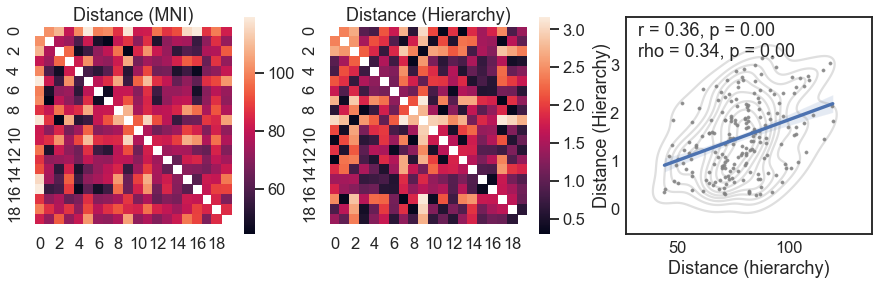

In [20]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(dist_mni, ax=ax[0], square = True)
ax[0].set_title('Distance (MNI)');
sns.heatmap(dist_h, ax=ax[1], square = True)
ax[1].set_title('Distance (Hierarchy)');
my_regplot(dist_mni[indices], dist_h[indices], 'Distance (hierarchy)', 'Distance (Hierarchy)', ax[2])
f.savefig(outfile_prefix+'disance_vs_distance.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

## Plot distances against energy

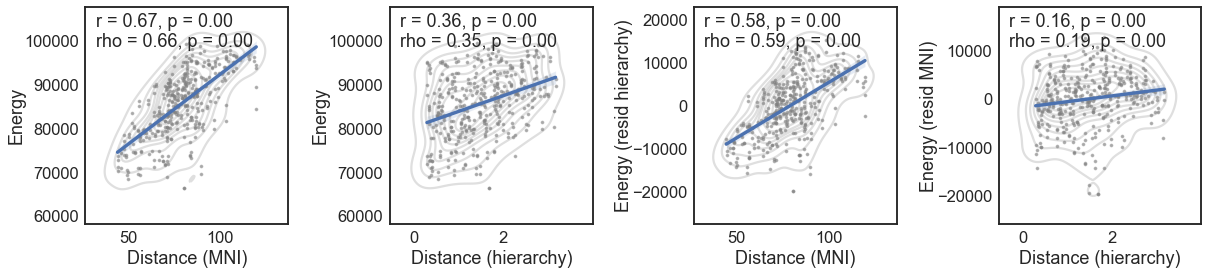

In [21]:
f, ax = plt.subplots(1, 4, figsize=(20, 4))
my_regplot(dist_mni[indices], E_Am[indices], 'Distance (MNI)', 'Energy', ax[0])
my_regplot(dist_h[indices], E_Am[indices], 'Distance (hierarchy)', 'Energy', ax[1])

E_Am_res = nuis_regress_matrix(E_Am, dist_h, indices)
my_regplot(dist_mni[indices], E_Am_res[indices], 'Distance (MNI)', 'Energy (resid hierarchy)', ax[2])
E_Am_res = nuis_regress_matrix(E_Am, dist_mni, indices)
my_regplot(dist_h[indices], E_Am_res[indices], 'Distance (hierarchy)', 'Energy (resid MNI)', ax[3])

f.subplots_adjust(wspace=0.5)
f.savefig(outfile_prefix+'energy_vs_distance.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

## Plot adj. stats

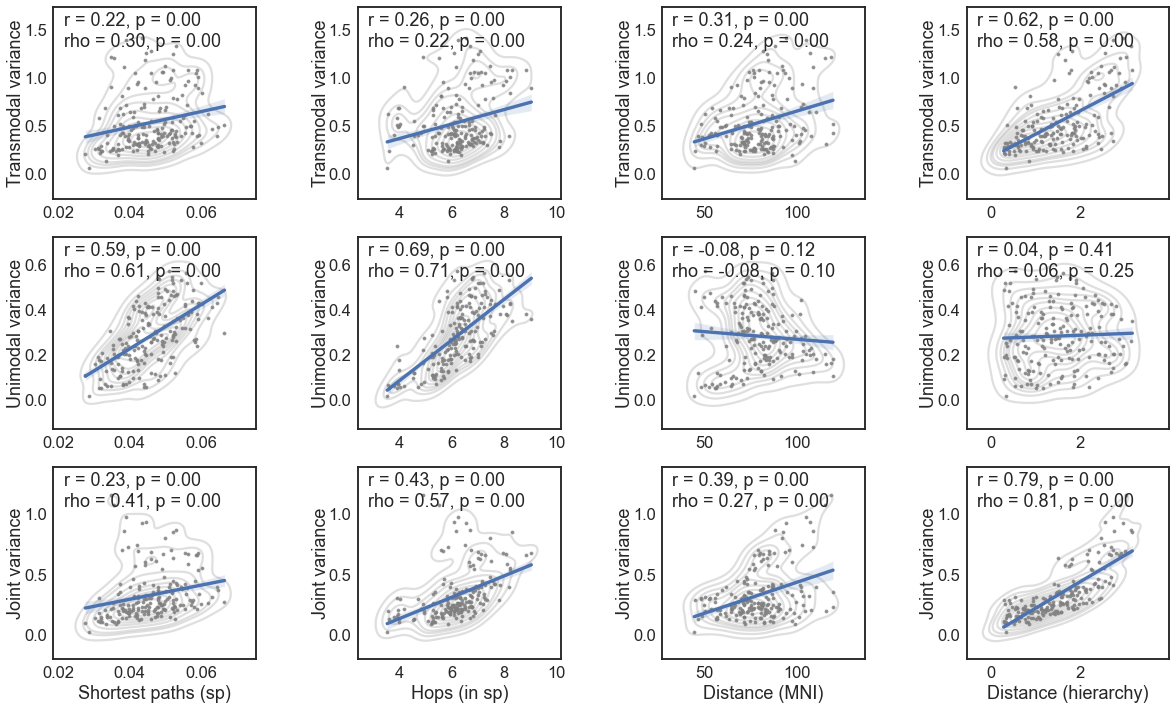

In [22]:
plot_var = tm_var[indices]; ylabel = 'Transmodal variance'
f, ax = plt.subplots(3, 4, figsize=(20, 12))
my_regplot(D_mean[indices], plot_var, '', ylabel, ax[0,0])
my_regplot(hops_mean[indices], plot_var, '', ylabel, ax[0,1])
my_regplot(dist_mni[indices], plot_var, '', ylabel, ax[0,2])
my_regplot(dist_h[indices], plot_var, '', ylabel, ax[0,3])

plot_var = smv_var[indices]; ylabel = 'Unimodal variance'
my_regplot(D_mean[indices], plot_var, '', ylabel, ax[1,0])
my_regplot(hops_mean[indices], plot_var, '', ylabel, ax[1,1])
my_regplot(dist_mni[indices], plot_var, '', ylabel, ax[1,2])
my_regplot(dist_h[indices], plot_var, '', ylabel, ax[1,3])

plot_var = joint_var[indices]; ylabel = 'Joint variance'
my_regplot(D_mean[indices], plot_var, 'Shortest paths (sp)', ylabel, ax[2,0])
my_regplot(hops_mean[indices], plot_var, 'Hops (in sp)', ylabel, ax[2,1])
my_regplot(dist_mni[indices], plot_var, 'Distance (MNI)', ylabel, ax[2,2])
my_regplot(dist_h[indices], plot_var, 'Distance (hierarchy)', ylabel, ax[2,3])

f.subplots_adjust(wspace=0.5)
f.savefig(outfile_prefix+'variance_vs_adjstats.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

## Plot adj. stats against energy

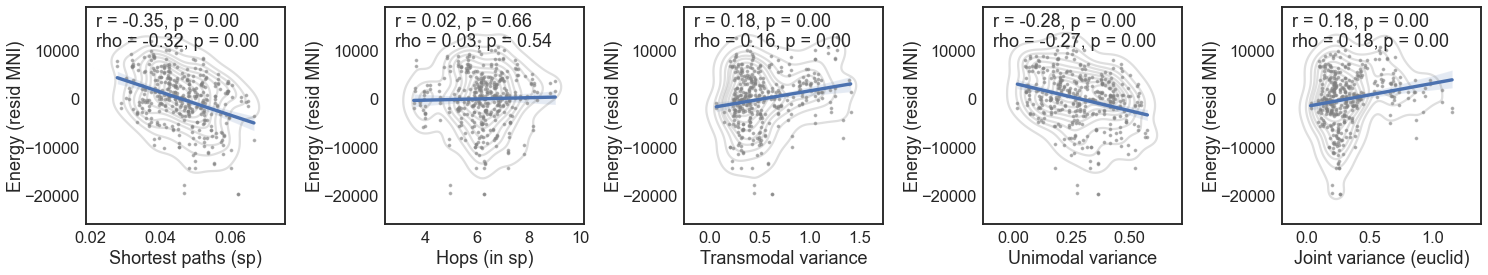

In [23]:
E_Am_res = nuis_regress_matrix(E_Am, dist_mni, indices); E_plot = E_Am_res; ylabel = 'Energy (resid MNI)'
# E_plot = E_Am; ylabel = 'Energy'

f, ax = plt.subplots(1, 5, figsize=(25, 4))
my_regplot(D_mean[indices], E_plot[indices], 'Shortest paths (sp)', ylabel, ax[0])
my_regplot(hops_mean[indices], E_plot[indices], 'Hops (in sp)', ylabel, ax[1])
my_regplot(tm_var[indices], E_plot[indices], 'Transmodal variance', ylabel, ax[2])
my_regplot(smv_var[indices], E_plot[indices], 'Unimodal variance', ylabel, ax[3])
my_regplot(joint_var[indices], E_plot[indices], 'Joint variance (euclid)', ylabel, ax[4])
# my_regplot(num_tm_flips[indices], E_plot[indices], 'Number flips (transmodal)', ylabel, ax[5])

f.subplots_adjust(wspace=0.5)
f.savefig(outfile_prefix+'energy_vs_adjstats_resid_mni.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

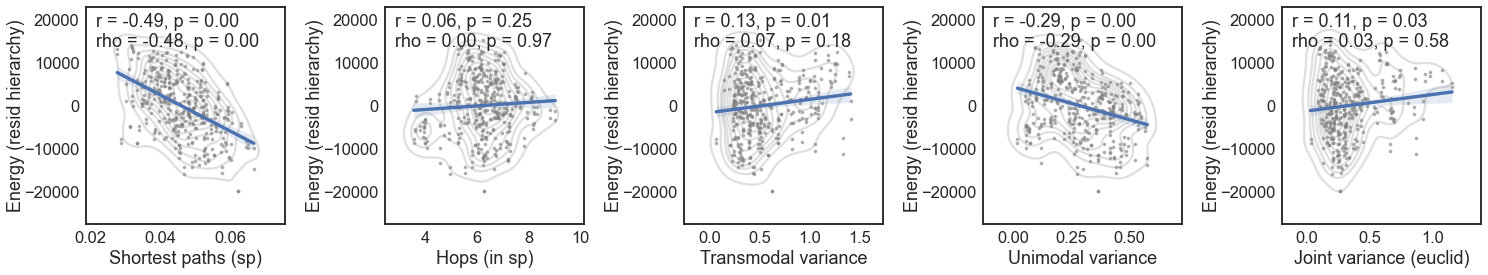

In [24]:
E_Am_res = nuis_regress_matrix(E_Am, dist_h, indices); E_plot = E_Am_res; ylabel = 'Energy (resid hierarchy)'
# E_plot = E_Am; ylabel = 'Energy'

f, ax = plt.subplots(1, 5, figsize=(25, 4))
my_regplot(D_mean[indices], E_plot[indices], 'Shortest paths (sp)', ylabel, ax[0])
my_regplot(hops_mean[indices], E_plot[indices], 'Hops (in sp)', ylabel, ax[1])
my_regplot(tm_var[indices], E_plot[indices], 'Transmodal variance', ylabel, ax[2])
my_regplot(smv_var[indices], E_plot[indices], 'Unimodal variance', ylabel, ax[3])
my_regplot(joint_var[indices], E_plot[indices], 'Joint variance (euclid)', ylabel, ax[4])
# my_regplot(num_tm_flips[indices], E_plot[indices], 'Number flips (transmodal)', ylabel, ax[5])

f.subplots_adjust(wspace=0.5)
f.savefig(outfile_prefix+'energy_vs_adjstats_resid_h.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)

# Null models

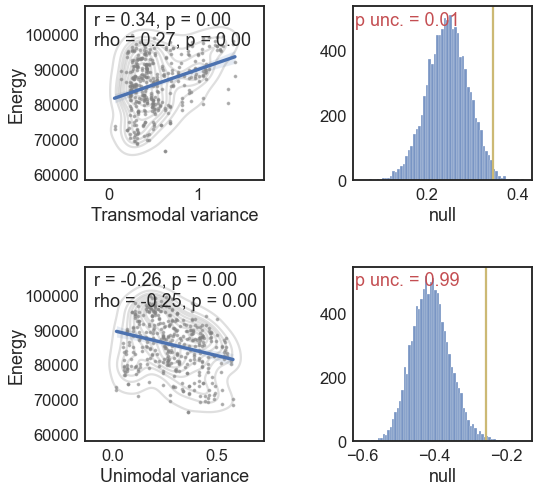

In [25]:
num_surrogates = 10000
surr_type = 'spatial_wssp' # 'standard' 'spatial_wwp' 'spatial_wsp' 'spatial_wssp'
# surr_type = surr_type+'_hybrid'
surr_type = surr_type+'_grad_cmni'
# surr_type = surr_type+'_mni_cgrad'

tm_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_tm_var_surr.npy'))
smv_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_smv_var_surr.npy'))
joint_var_surr = np.load(os.path.join(os.environ['PIPELINEDIR'], '4_compute_adj_stats_surrogates', 'out', outfile_prefix[:-1], 'disc_mean_A_s6_'+surr_type+'_grad'+str(n_clusters)+'_joint_var_surr.npy'))

if tm_var_surr.shape[2] > num_surrogates:
    tm_var_surr = tm_var_surr[:,:,:num_surrogates]
    smv_var_surr = smv_var_surr[:,:,:num_surrogates]
    joint_var_surr = joint_var_surr[:,:,:num_surrogates]

# E_Am_res = nuis_regress_matrix(E_Am, dist_h, indices); E_plot = E_Am_res; ylabel = 'Energy (resid hierarchy)'
E_plot = E_Am; ylabel = 'Energy'
f, ax = plt.subplots(2, 2, figsize=(8, 8))

my_regplot(tm_var[indices], E_plot[indices], 'Transmodal variance', 'Energy', ax[0,0])
my_nullplot(tm_var[indices], tm_var_surr[indices], E_plot[indices], 'null', ax=ax[0,1])

my_regplot(smv_var[indices], E_plot[indices], 'Unimodal variance', 'Energy', ax[1,0])
my_nullplot(smv_var[indices], smv_var_surr[indices], E_plot[indices], 'null', ax=ax[1,1])

f.subplots_adjust(wspace=0.5, hspace=0.5)
f.savefig(outfile_prefix+'energy_vs_adjstats_null.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.1)    